In [1]:
'''
Zé Fonseca

11/01/16

Notes: Data sets at classes and cases inside each dataset is a subclass
'''

import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, splrep, splev, bisplrep, bisplev
import sys

%matplotlib inline

# Part 1

## Simulating data

### Cases:
* 1: N_SNeIa=1000, z-[0.015,1.0], \sigma_mu=0.2 (both in the distribution and in the error bar), no z scatter;
* 2.1: z scatter=0.04*(1+z) but all z are positive 
* 2.2: z scatter=0.04*(1+z) only for z>0.1 (bellow we expect to have spectroscopic info)
* 3: 9% of the z are wrong (but we don't know which ones), on avarage Delta_z\sim 0.1

Note that for now error bars on mu will be given by 0.2. Error propagation in quadrature will be done later.

In [2]:
#cosmological functions
#general functions
def H(z,OM,H0,w):
    if w==-1:
        return H0*sp.sqrt(OM*(1+z)**3+(1-OM))
    else:
        return H0*sp.sqrt(OM*(1+z)**3+(1-OM)*(1+z)**(3*(w+1)))

c=2.99792e5

def dL(z,OM,H0,w):
    return (1+z)*quad(lambda x:c/H(x,OM,H0,w),0,z)[0]

def mu(z,OM,H0,w):
    return 5*sp.log10(dL(z,OM,H0,w))+25



#class fake data with all the cases.

class fkd:
    def __init__(self,N=1000,z_min=0.015,z_max=1.0,OM=0.31,H0=67.74,w=-1,sig_mu=0.2):
        #parameters used
        self.N=N
        self.z_min=z_min
        self.z_max=z_max
        self.OM=OM
        self.H0=H0
        self.w=w


        #get redshifts
        z=np.random.rand(N)*(z_max-z_min)+z_min
        z.sort()
        self.z=z
        
        #get magnitudes
        mu_t=np.array([mu(zi,OM,H0,w) for zi in z])
        mu_o=mu_t+np.random.randn(N)*sig_mu
        self.mu_t=mu_t
        self.mu_o=mu_o
        self.sig_mu=sig_mu
        self.err_mu=sig_mu*np.ones(N)
        
    class case21(object):
        pass
    
    class case22(object):
        pass
    
    class case3(object):
        pass
    
    def bias_sets_case21(self,error_z21=0.04):
        z_b21=np.zeros(len(self.z))
        for i in range(len(self.z)):
            z_b21[i]=self.z[i]+np.random.randn()*error_z21*(1+self.z[i])
            while z_b21[i]<=0:
                z_b21[i]=self.z[i]+np.random.randn()*error_z21*(1+self.z[i])
        
        self.case21.z=z_b21
        self.case21.mu_o=self.mu_o
        self.case21.err_mu=self.err_mu
        self.case21.sig_mu=self.sig_mu
        #mu error will be changed in MCMC
        self.case21.error_z=error_z21
        
    def bias_sets_case22(self,error_z22=0.04):
        z_b22=np.zeros(len(self.z))
        for i in range(len(self.z)):
            if self.z[i]<=0.1:
                z_b22[i]=self.z[i]
            else:
                z_b22[i]=self.z[i]+np.random.randn()*error_z22*(1+self.z[i])
                while z_b22[i]<=0:
                    z_b22[i]=self.z[i]+np.random.randn()*error_z22*(1+self.z[i])
                    
        self.case22.z=z_b22
        self.case22.mu_o=self.mu_o
        self.case22.err_mu=self.err_mu
        self.case22.error_z=error_z22
        self.case22.sig_mu=self.sig_mu
    
    def bias_sets_case3(self,dz_3=0.1):
        
        z_b3=np.zeros(len(self.z))
        #second possible galaxy
        z_b3_2=np.zeros(len(self.z))
        for i in range(len(self.z)):
            if self.z[i]<=0.1:
                z_b3[i]=self.z[i]
                z_b3_2[i]=self.z[i]
            else:
                pvalue=np.random.rand()
                if pvalue>0.09:
                    z_b3[i]=self.z[i]
                    z_b3_2[i]=self.z[i]+np.random.randn()*dz_3
                    while z_b3_2[i]<=0:
                        z_b3_2[i]=self.z[i]+np.random.randn()*dz_3
                else:
                    z_b3[i]=self.z[i]+np.random.randn()*dz_3
                    z_b3_2[i]=self.z[i]
                    while z_b3[i]<=0:
                        z_b3[i]=self.z[i]+np.random.randn()*dz_3
                    
        
        self.case3.z=z_b3
        self.case3.z2=z_b3_2
        self.case3.mu_o=self.mu_o
        self.case3.err_mu=self.err_mu
        self.case3.dz=dz_3
        self.case3.sig_mu=self.sig_mu

In [27]:
#initiate data and simulate it
fd3=fkd()
fd3.bias_sets_case21()
fd3.bias_sets_case22()
fd3.bias_sets_case3()

In [36]:
# save data and plot it

def save_sim_data(data,dataset,case):
    if case==3:
        np.savetxt('data_'+dataset+'_case'+str(case)+'_zf.txt',np.c_[data.z,data.z2,data.mu_o],fmt='%2.3f',\
           header='\n'.join(["Error in mu %.2f" %data.sig_mu, "z   z2   mu"]))
    else:
        np.savetxt('data_'+dataset+'_case'+str(case)+'_zf.txt',np.c_[data.z,data.mu_o],fmt='%2.3f',\
           header='\n'.join(["Error in mu %.2f" %data.sig_mu, "z   mu"]))
dataset='fd3'        
save_sim_data(fd3,dataset,1)
save_sim_data(fd3.case21,dataset,21)
save_sim_data(fd3.case22,dataset,22)
save_sim_data(fd3.case3,dataset,3)


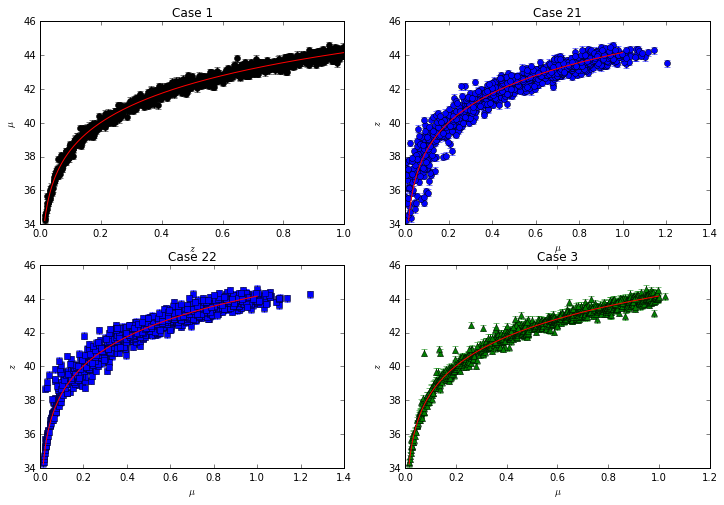

In [29]:
f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[1,1],'height_ratios':[1,1]})
axarr[0,0].errorbar(fd3.z,fd3.mu_o,yerr=[fd3.err_mu,fd3.err_mu],fmt='ko')
axarr[0,0].plot(fd3.z,fd3.mu_t,'r')
axarr[0,0].set_xlabel(r'$z$')
axarr[0,0].set_ylabel(r'$\mu$')
axarr[0,0].set_title('Case 1')
    
axarr[0,1].errorbar(fd3.case21.z,fd3.case21.mu_o,yerr=[fd3.case21.err_mu,fd3.case21.err_mu],fmt='bo')
axarr[0,1].plot(fd3.z,fd3.mu_t,'r')
axarr[0,1].set_ylabel(r'$z$')
axarr[0,1].set_xlabel(r'$\mu$')
axarr[0,1].set_title('Case 21')

axarr[1,0].errorbar(fd3.case22.z,fd3.case22.mu_o,yerr=[fd3.case22.err_mu,fd3.case22.err_mu],fmt='bs')
axarr[1,0].plot(fd3.z,fd3.mu_t,'r')
axarr[1,0].set_ylabel(r'$z$')
axarr[1,0].set_xlabel(r'$\mu$')
axarr[1,0].set_title('Case 22')   

axarr[1,1].errorbar(fd3.case3.z,fd3.case3.mu_o,yerr=[fd3.case3.err_mu,fd3.case3.err_mu],fmt='g^')
axarr[1,1].plot(fd3.z,fd3.mu_t,'r')
axarr[1,1].set_ylabel(r'$z$')
axarr[1,1].set_xlabel(r'$\mu$')
axarr[1,1].set_title('Case 3') 

plt.savefig('datasets_allcases_fd3_zf.pdf')
plt.show()

# Part 2

## Do the MCMC to the data

Notes: when adding errors in MCMC we need 3 different error adding. Case 3 does not have mu errors increased in quadrature. 

In [52]:
# Functions
def interpoler_mu(OM,H0,w,z_data):
    z_spl = np.linspace(min(z_data), max(z_data),100)
    mu_spl = np.array([mu(z_spli,OM,H0,w) for z_spli in z_spl])
    mu_spl_rep = splrep(z_spl, mu_spl)
    mu_theory=splev(z_data, mu_spl_rep)
    return mu_theory

#MCMC priors
def prior_om(x):
    if x>=0 and x<=1:
        return 1
    else:
        return 0
    
def prior_w(x):
    if x>=-2 and x<=1:
        return 1
    else:
        return 0
    
def prior_H0(x):
    if x>=30 and x<=80:
        return 1
    else:
        return 0
    
def chi2(mu_o,mu_t,sigma):
    return sum((mu_o-mu_t)**2/sigma**2)
    
def dmudz(z,mu,OM=0.31,H0=67.74,w=-1):
    return 5/np.log(10)*(1/(1+z)+(1+z)*c/(H(z,OM,H0,w)*10**(mu/5-5)))

def MCMC_SNe(N,data,z_noise=False,milne=False):
    #create arrays
    o_m=np.zeros(N)
    w=np.zeros(N)
    H0=np.zeros(N)
    chi2_mcmc=np.zeros(N)
    
    #set starting point
    o_m[0]=np.random.rand()*0.1+0.25
    w[0]=np.random.rand()*0.2-1.1
    H0[0]=np.random.rand()*5+65
    
    #first point
    mu_t=interpoler_mu(o_m[0],H0[0],w[0],data.z)
    err_mu=data.err_mu
    
    if z_noise==True:
        err_mu=np.sqrt(data.err_mu**2+(dmudz(data.z,mu_t,o_m[0],H0[0],w[0])*data.error_z*(1+data.z))**2)
    elif milne==True:
        err_mu=np.sqrt(data.err_mu**2+(10/np.log(10)*(1+data.z)/data.z/(data.z+2)*data.error_z*(1+data.z))**2)
    
    chi2_mcmc[0]=chi2(data.mu_o,mu_t,err_mu)
    
    #dummy var for acceptance rate
    naccept=0
    for i in range(N-1):
        #if i%5000==0:
        #    print(accept)
            
        #get new point
        o_m[i+1]=o_m[i]+np.random.randn()*0.04
        w[i+1]=w[i]+np.random.randn()*0.04
        H0[i+1]=H0[i]+np.random.randn()*0.9
        
        
        
        if prior_om(o_m[i+1])==0 or prior_w(w[i+1])==0 or prior_H0(H0[i+1])==0:
            r=0.0
            o_m[i+1]=o_m[i]
            w[i+1]=w[i]
            H0[i+1]=H0[i]
            chi2_mcmc[i+1]=chi2_mcmc[i]
            naccept+=1
            next
        else:
            
            #compute chi2
            mu_t=interpoler_mu(o_m[i+1],H0[i+1],w[i+1],data.z)
            
            if z_noise==True:
                err_mu=np.sqrt(data.err_mu**2+(dmudz(data.z,mu_t,o_m[i+1],H0[i+1],w[i+1])*data.error_z*(1+data.z))**2)
            
            chi2_mcmc[i+1]=chi2(data.mu_o,mu_t,err_mu)
            #if priors not flat they need to be included after the exp
            r=sp.exp(-(chi2_mcmc[i+1]-chi2_mcmc[i])/2)
            #accept or not
            teste=np.random.rand()
            if r<teste:
                o_m[i+1]=o_m[i]
                w[i+1]=w[i]
                H0[i+1]=H0[i]
                chi2_mcmc[i+1]=chi2_mcmc[i]
                naccept+=1 
            
        #really cool piece of code from Ethan
        inc100 = np.int64(i/(N-2)*100)
        inc50 = np.int64(i/(N-2)*50)
        sys.stdout.write('\r')
        sys.stdout.write('[' + '#'*inc50 + ' '*(50-inc50) + ']' + str(inc100) + '%')
        sys.stdout.flush()
        
    acceptr=(N-naccept)/N*100
    
    data.nsteps=N
    
    if z_noise==True:
        data.zn_chain_o_m=o_m
        data.zn_chain_w=w
        data.zn_chain_H0=H0
        data.zn_chi2_mcmc=chi2_mcmc
        data.zn_acceptr=acceptr
    elif milne==True:
        data.milne_chain_o_m=o_m
        data.milne_chain_w=w
        data.milne_chain_H0=H0
        data.milne_chi2_mcmc=chi2_mcmc
        data.milne_acceptr=acceptr
    else:
        data.chain_o_m=o_m
        data.chain_w=w
        data.chain_H0=H0
        data.chi2_mcmc=chi2_mcmc
        data.acceptr=acceptr

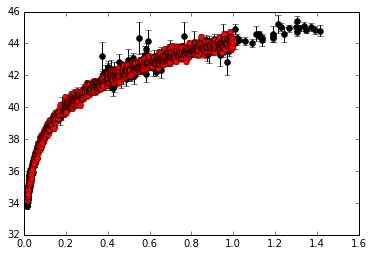

In [7]:
# First test
# check with Union 2.0 data
union21=fkd()
#load Union2.1 data
dados=np.loadtxt('SCPUnion2.1_mu_vs_z.txt',usecols=[1,2,3])
union21.z=dados[:,0]
union21.mu_o=dados[:,1]
union21.err_mu=dados[:,2]

plt.errorbar(union21.z,union21.mu_o,yerr=[union21.err_mu,union21.err_mu],fmt='ko')
plt.errorbar(fd3.z,fd3.mu_o,yerr=[fd3.err_mu,fd3.err_mu],fmt='ro')
plt.show()


In [13]:
MCMC_SNe(50000,union21)
print('\n',union21.acceptr) 

[##################################################]100%
 15.692


## Make plots

In [14]:
def plot_sct_hist(data1,data2,case,z_noise=False,milne=False,burn_tail=100,thining=1,nb=20,dataset='fd1'):    
    #o_m,w,H0,case,dataset,,hotext=[66,6000]):
    f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
    if z_noise==True:
        case=case+' with photometric error propagation in quadrature'
        caset=case+'_zn'
        om2=data2.zn_chain_o_m[burn_tail::thining]
        w2=data2.zn_chain_w[burn_tail::thining]
        H02=data2.zn_chain_H0[burn_tail::thining]
    elif milne==True:
        case=case+' with photometric error propagation as in Milne'
        caset=case+'_milne'
        om2=data2.milne_chain_o_m[burn_tail::thining]
        w2=data2.milne_chain_w[burn_tail::thining]
        H02=data2.milne_chain_H0[burn_tail::thining]
        
    else:
        om2=data2.chain_o_m[burn_tail::thining]
        w2=data2.chain_w[burn_tail::thining]
        H02=data2.chain_H0[burn_tail::thining]
        caset=case
    
    f.text(0.5, 0.95, 'Bias: '+dataset+', Case '+case,horizontalalignment='center',verticalalignment='top')
    
    om_min=min(np.amin(data1.chain_o_m[burn_tail::thining]),np.amin(om2))
    om_max=max(np.amax(data1.chain_o_m[burn_tail::thining]),np.amax(om2))
    
    w_min=min(np.amin(data1.chain_w[burn_tail::thining]),np.amin(w2))
    w_max=max(np.amax(data1.chain_w[burn_tail::thining]),np.amax(w2))
    
    H0_min=min(np.amin(data1.chain_H0[burn_tail::thining]),np.amin(H02))
    H0_max=max(np.amax(data1.chain_H0[burn_tail::thining]),np.amax(H02))
    
    axarr[0,0].hist(data1.chain_o_m[burn_tail::thining],color='r',bins=nb,alpha=0.2)
    axarr[0,0].set_xlim([om_min,om_max])
    axarr[0,0].hist(om2,color='b',bins=nb,alpha=0.2)
    
    axarr[1,0].scatter(data1.chain_o_m[burn_tail::thining],data1.chain_w[burn_tail::thining],color='r',alpha=0.05)
    axarr[1,0].scatter(om2,w2,color='b',alpha=0.05)
    axarr[1,0].set_xlim([om_min,om_max])
    axarr[1,0].set_ylim([w_min,w_max])
    axarr[1,0].set_ylabel(r'$w$')
    axarr[1,0].set_xlabel(r'$\Omega_M$')
    
    axarr[0,1].hist(data1.chain_H0[burn_tail::thining],bins=nb,color='r',alpha=0.2)
    axarr[0,1].hist(H02,bins=nb,color='b',alpha=0.2)
    axarr[0,1].set_xlim([H0_min,H0_max])
    axarr[0,1].set_xlabel(r'$H_0$')
    
    axarr[1,1].hist(data1.chain_w[burn_tail::thining],bins=nb,color='r',alpha=0.2,orientation=u'horizontal')
    axarr[1,1].hist(w2,bins=nb,color='b',alpha=0.2,orientation=u'horizontal')
    axarr[1,1].set_ylim([w_min,w_max])
    
    plt.savefig('bias_'+dataset+caset+'_zf.pdf')
    
    plt.show()


def confidence_levels(Hist,N):
    H2d=Hist.ravel()
    H2d = np.sort(H2d)
    tot=np.cumsum(H2d)
    Nmax=H2d[-1]
    N95=H2d[np.argwhere(tot>0.05*N)[0,0]]
    N68=H2d[np.argwhere(tot>0.32*N)[0,0]]
    return Nmax,N68,N95

def plot_contour_hist(data1,data2,case,z_noise=False,milne=False,burn_tail=100,thining=1,nb=20,dataset='fd1'):    
    #o_m,w,H0,case,dataset,,hotext=[66,6000]):
    f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
    
    
    Hist_mcmc, omedges,wedges = np.histogram2d(data1.chain_o_m[burn_tail::thining],data1.chain_w[burn_tail::thining],bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Neff=len(data1.chain_o_m[burn_tail::thining])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Neff)
    #plt.plot(om_max,w_max,'rx',ms=10)
    
    
    if z_noise==True:
        case=case+' with photometric error propagation in quadrature'
        caset=case+'_zn'
        om2=data2.zn_chain_o_m[burn_tail::thining]
        w2=data2.zn_chain_w[burn_tail::thining]
        H02=data2.zn_chain_H0[burn_tail::thining]
        Hist_mcmc2, omedges2,wedges2 = np.histogram2d(om2,w2,bins=(nb, nb))
        om_c2=np.array([(omedges2[i]+omedges2[i+1])/2 for i in range(len(omedges2)-1)])
        w_c2=np.array([(wedges2[i]+wedges2[i+1])/2 for i in range(len(wedges2)-1)])
        Neff2=len(om2)
        Nmax2,N682,N952=confidence_levels(Hist_mcmc2,Neff2)
    elif milne==True:
        case=case+' with photometric error propagation as in Milne'
        caset=case+'_milne'
        om2=data2.milne_chain_o_m[burn_tail::thining]
        w2=data2.milne_chain_w[burn_tail::thining]
        H02=data2.milne_chain_H0[burn_tail::thining]
        Hist_mcmc2, omedges2,wedges2 = np.histogram2d(om2,w2,bins=(nb, nb))
        om_c2=np.array([(omedges2[i]+omedges2[i+1])/2 for i in range(len(omedges2)-1)])
        w_c2=np.array([(wedges2[i]+wedges2[i+1])/2 for i in range(len(wedges2)-1)])
        Neff2=len(om2)
        Nmax2,N682,N952=confidence_levels(Hist_mcmc2,Neff2)
        
    else:
        caset=case
        om2=data2.chain_o_m[burn_tail::thining]
        w2=data2.chain_w[burn_tail::thining]
        H02=data2.chain_H0[burn_tail::thining]
        Hist_mcmc2, omedges2,wedges2 = np.histogram2d(om2,w2,bins=(nb, nb))
        om_c2=np.array([(omedges2[i]+omedges2[i+1])/2 for i in range(len(omedges2)-1)])
        w_c2=np.array([(wedges2[i]+wedges2[i+1])/2 for i in range(len(wedges2)-1)])
        Neff2=len(om2)
        Nmax2,N682,N952=confidence_levels(Hist_mcmc2,Neff2)
    
    f.text(0.5, 0.95, 'Bias: '+dataset+', Case '+case,horizontalalignment='center',verticalalignment='top')
    
    om_min=min(np.amin(data1.chain_o_m[burn_tail::thining]),np.amin(om2))
    om_max=max(np.amax(data1.chain_o_m[burn_tail::thining]),np.amax(om2))
    
    w_min=min(np.amin(data1.chain_w[burn_tail::thining]),np.amin(w2))
    w_max=max(np.amax(data1.chain_w[burn_tail::thining]),np.amax(w2))
    
    H0_min=min(np.amin(data1.chain_H0[burn_tail::thining]),np.amin(H02))
    H0_max=max(np.amax(data1.chain_H0[burn_tail::thining]),np.amax(H02))
    
    axarr[0,0].hist(data1.chain_o_m[burn_tail::thining],color='r',bins=nb,alpha=0.2)
    axarr[0,0].set_xlim([om_min,om_max])
    axarr[0,0].hist(om2,color='b',bins=nb,alpha=0.2)
    
    import matplotlib as mpl
    colors1 = [(1.0, 0.0, 0.0, 0.7),(1.0, 0.0, 0.0, 0.4)] 
    cmap1 = mpl.colors.ListedColormap(colors1)
    colors2 = [(0.0, 0.0, 1.0, 0.7),(0.0, 0.0, 1.0, 0.4)] 
    cmap2 = mpl.colors.ListedColormap(colors2)
    
    axarr[1,0].contourf(om_c,w_c, Hist_mcmc.T,levels=[N95,N68,Nmax], cmap=cmap1)
    axarr[1,0].contourf(om_c2,w_c2, Hist_mcmc2.T,levels=[N952,N682,Nmax2],cmap=cmap2)
    axarr[1,0].set_xlim([om_min,om_max])
    axarr[1,0].set_ylim([w_min,w_max])
    axarr[1,0].set_ylabel(r'$w$')
    axarr[1,0].set_xlabel(r'$\Omega_M$')
    
    axarr[0,1].hist(data1.chain_H0[burn_tail::thining],bins=nb,color='r',alpha=0.2)
    axarr[0,1].hist(H02,bins=nb,color='b',alpha=0.2)
    axarr[0,1].set_xlim([H0_min,H0_max])
    axarr[0,1].set_xlabel(r'$H_0$')
    
    axarr[1,1].hist(data1.chain_w[burn_tail::thining],bins=nb,color='r',alpha=0.2,orientation=u'horizontal')
    axarr[1,1].hist(w2,bins=nb,color='b',alpha=0.2,orientation=u'horizontal')
    axarr[1,1].set_ylim([w_min,w_max])
    
    plt.savefig('bias_'+dataset+caset+'_zf.pdf')
    
    plt.show()
    
def plot_conv_mcmc(data,case,z_noise=False,milne=False,burn_tail=100,thining=1,dataset='fd1'):
    f, axarr = plt.subplots(3,1,figsize=(8,12))
    
    if z_noise==True:
        case=case+' with photometric error propagation in quadrature'
        caset=case+'_zn'
        om=data.zn_chain_o_m[burn_tail::thining]
        w=data.zn_chain_w[burn_tail::thining]
        H0=data.zn_chain_H0[burn_tail::thining]
    elif milne==True:
        case=case+' with photometric error propagation as in Milne'
        caset=case+'_milne'
        om=data.milne_chain_o_m[burn_tail::thining]
        w=data.milne_chain_w[burn_tail::thining]
        H0=data.milne_chain_H0[burn_tail::thining]        
    else:
        caset=case
        om=data.chain_o_m[burn_tail::thining]
        w=data.chain_w[burn_tail::thining]
        H0=data.chain_H0[burn_tail::thining]
    
    f.text(0.5, 0.95, 'Convergence: '+dataset+': '+case,
         horizontalalignment='center',
         verticalalignment='top')
    axarr[0].plot(om)
    axarr[0].set_ylim([np.amin(om),np.amax(om)])
    axarr[0].set_ylabel(r'$\Omega_M$')
    
    axarr[1].plot(w)
    axarr[1].set_ylim([np.amin(w),np.amax(w)])
    axarr[1].set_ylabel(r'$w$')
    
    axarr[2].plot(H0)
    axarr[2].set_ylim([np.amin(H0),np.amax(H0)])
    axarr[2].set_ylabel(r'$H_0$')
    
    plt.setp(axarr[0].get_xticklabels(), visible=False)
    plt.setp(axarr[1].get_xticklabels(), visible=False)
    
    plt.savefig('convergence_'+dataset+'_'+caset+'_zf.pdf')
    plt.show()

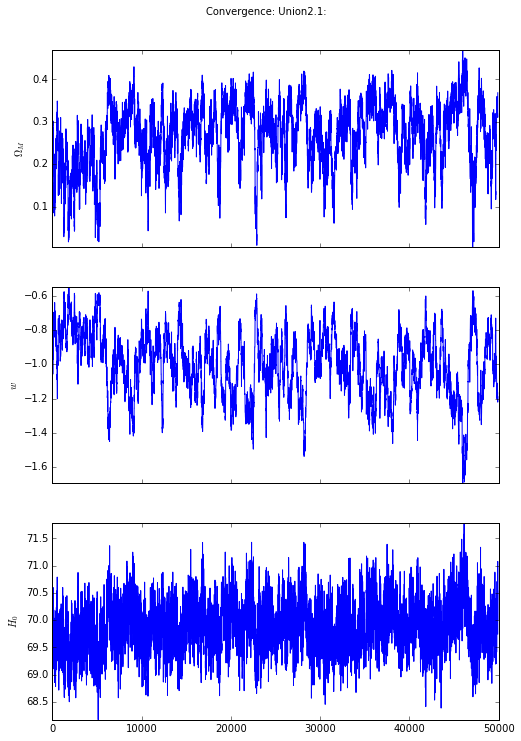

In [15]:
plot_conv_mcmc(union21,'',dataset='Union2.1')

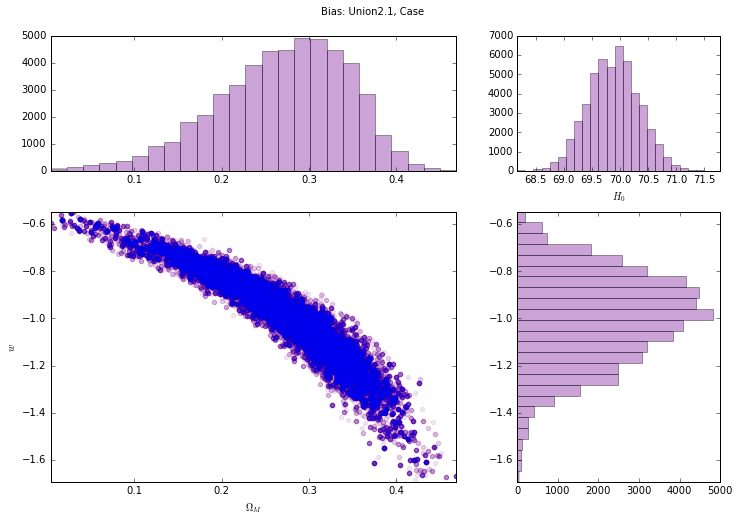

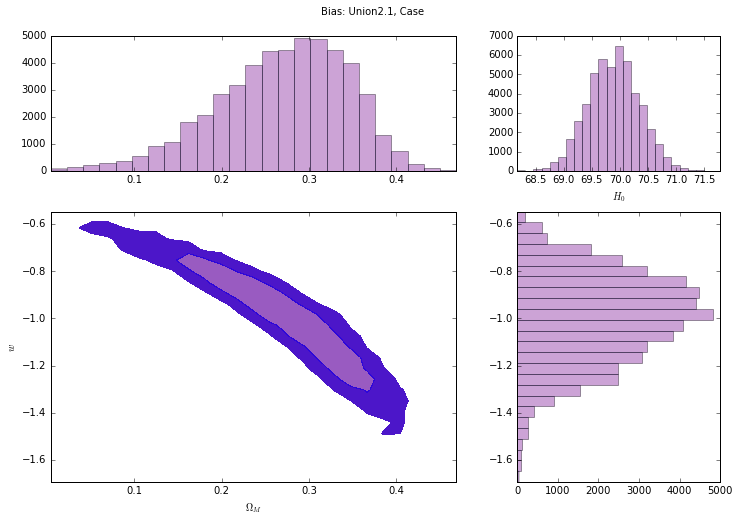

In [22]:
plot_sct_hist(union21,union21,'',dataset='Union2.1',nb=25)
plot_contour_hist(union21,union21,'',dataset='Union2.1',nb=25)

In [28]:
# Do for the fake dataset 3

MCMC_SNe(50000,fd3)
print('\n',fd3.acceptr)

[##################################################]100%
 11.686


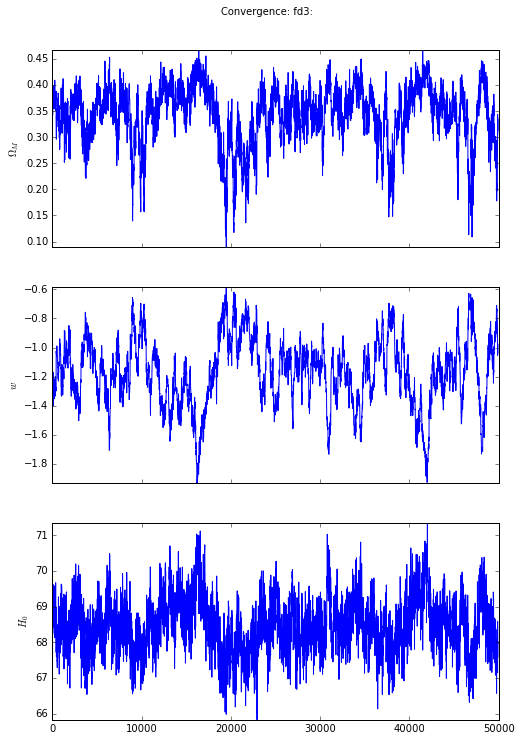

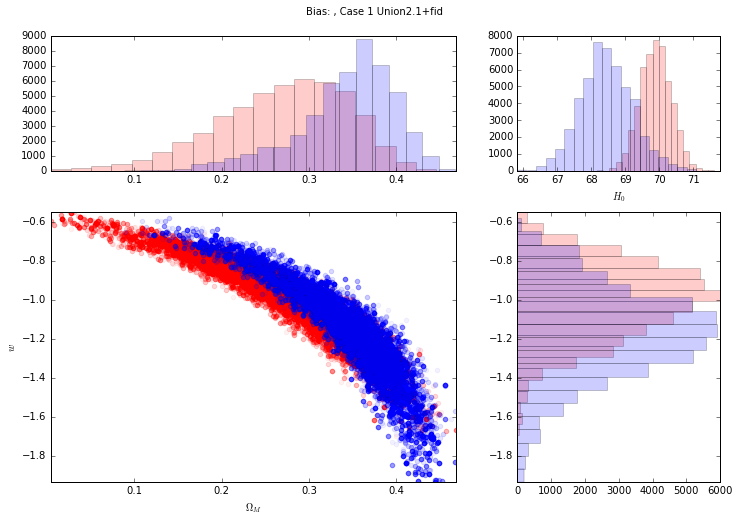

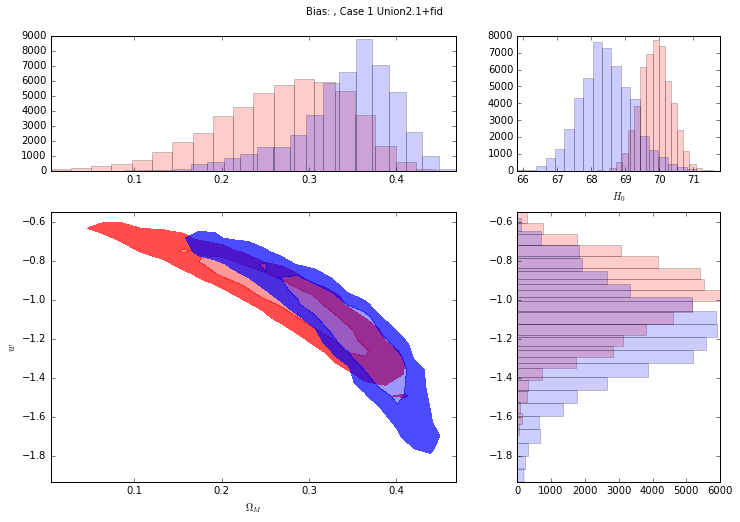

In [37]:
plot_conv_mcmc(fd3,'',dataset='fd3')
plot_sct_hist(union21,fd3,'1 Union2.1+fid',dataset='',nb=20)
plot_contour_hist(union21,fd3,'1 Union2.1+fid',dataset='',nb=20)

In [35]:
def save_mcmc(data,name,z_noise=False,milne=False):
    if z_noise==True:
        np.savetxt('mcmc_'+name+'_zf.txt',np.c_[data.zn_chain_o_m,data.zn_chain_w,data.zn_chain_H0,data.zn_chi2_mcmc],\
                   fmt=['%2.3f','%2.3f','%2.3f','%2.3e'], header='\n'.join(["acceptance rate %.2f" %data.zn_acceptr,\
                                                                            "Om   w   H0   chi2"]))
    elif milne==True:
        np.savetxt('mcmc_'+name+'_zf.txt',np.c_[data.milne_chain_o_m,data.milne_chain_w,data.milne_chain_H0,data.milne_chi2_mcmc],\
                   fmt=['%2.3f','%2.3f','%2.3f','%2.3e'], header='\n'.join(["acceptance rate %.2f" %data.milne_acceptr,\
                                                                            "Om   w   H0   chi2"]))
    else:
        np.savetxt('mcmc_'+name+'_zf.txt',np.c_[data.chain_o_m,data.chain_w,data.chain_H0,data.chi2_mcmc],\
                   fmt=['%2.3f','%2.3f','%2.3f','%2.3e'],header='\n'.join(["acceptance rate %.2f" %data.acceptr,\
                                                                           "Om   w   H0   chi2"]))
save_mcmc(fd3,'fd3_case1')
save_mcmc(union21,'union21_case1')

## Run for other cases

In [47]:
MCMC_SNe(50000,fd3.case21)
print('\n',fd3.case21.acceptr)
MCMC_SNe(50000,fd3.case22)
print('\n',fd3.case22.acceptr)
MCMC_SNe(50000,fd3.case3)
print('\n',fd3.case3.acceptr)

[##################################################]100%
 9.014
[##################################################]100%
 15.642
[##################################################]100%
 12.709999999999999


In [48]:
save_mcmc(fd3.case21,'fd3_case21')
save_mcmc(fd3.case22,'fd3_case2')
save_mcmc(fd3.case3,'fd3_case3')

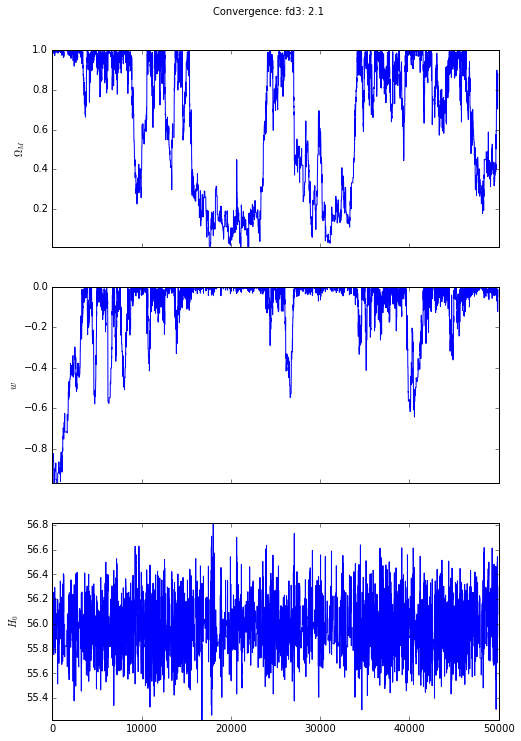

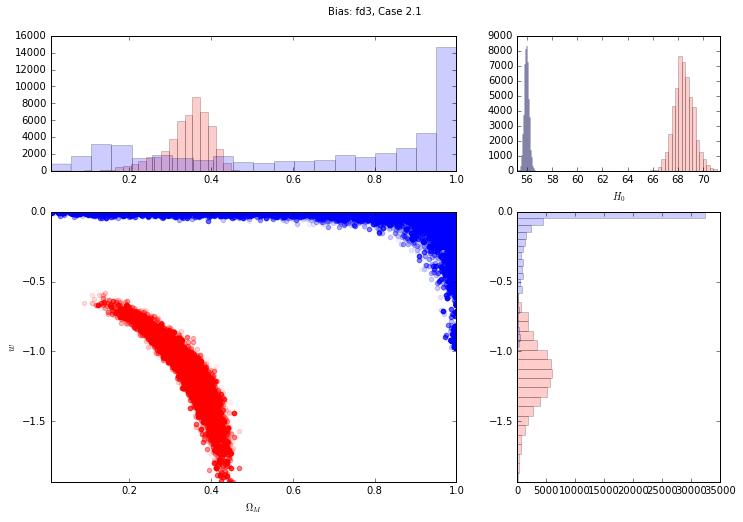

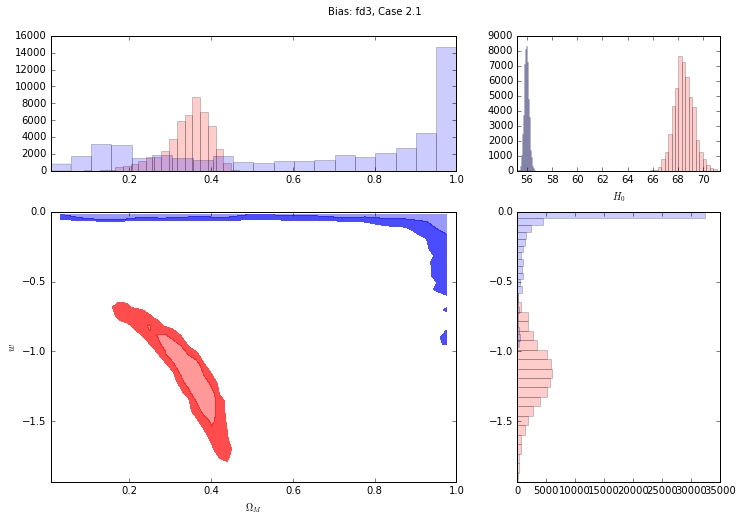

In [53]:
plot_conv_mcmc(fd3.case21,'2.1',dataset='fd3')
plot_sct_hist(fd3,fd3.case21,'2.1',dataset='fd3',nb=20)
plot_contour_hist(fd3,fd3.case21,'2.1',dataset='fd3',nb=20)

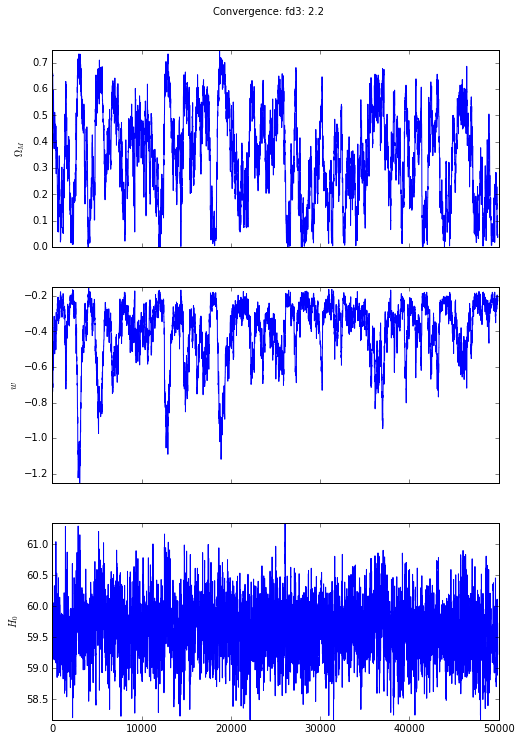

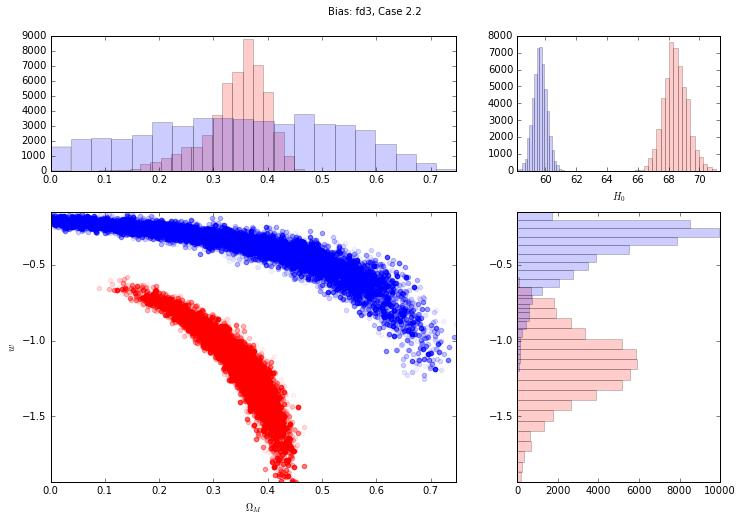

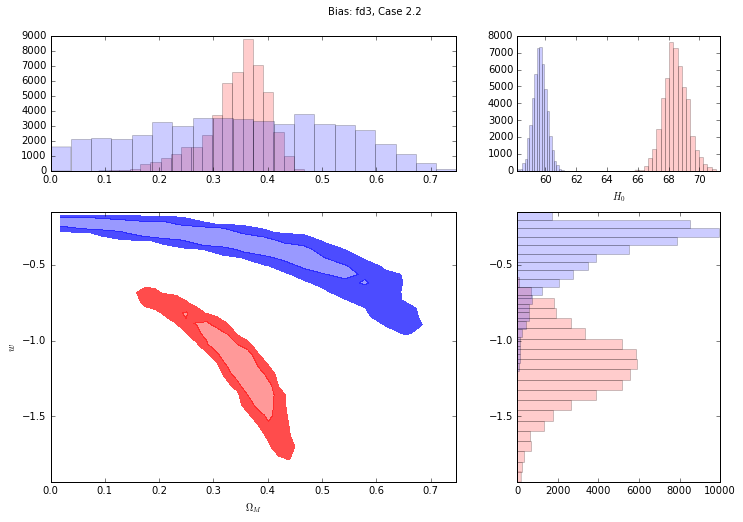

In [54]:
plot_conv_mcmc(fd3.case22,'2.2',dataset='fd3')
plot_sct_hist(fd3,fd3.case22,'2.2',dataset='fd3',nb=20)
plot_contour_hist(fd3,fd3.case22,'2.2',dataset='fd3',nb=20)

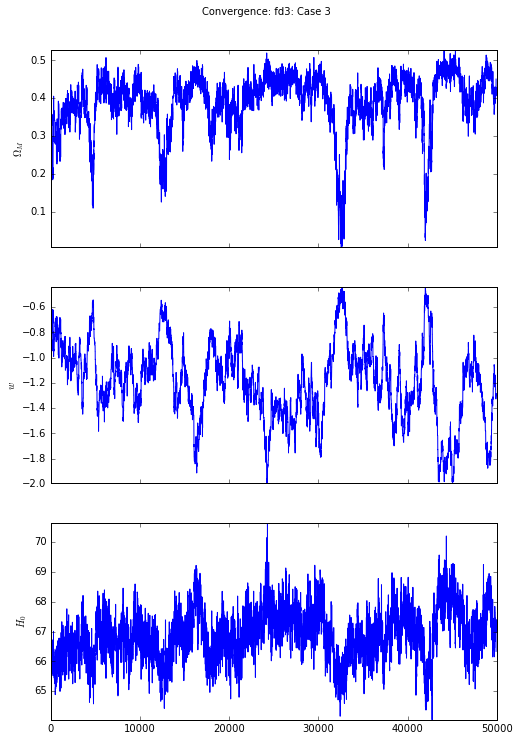

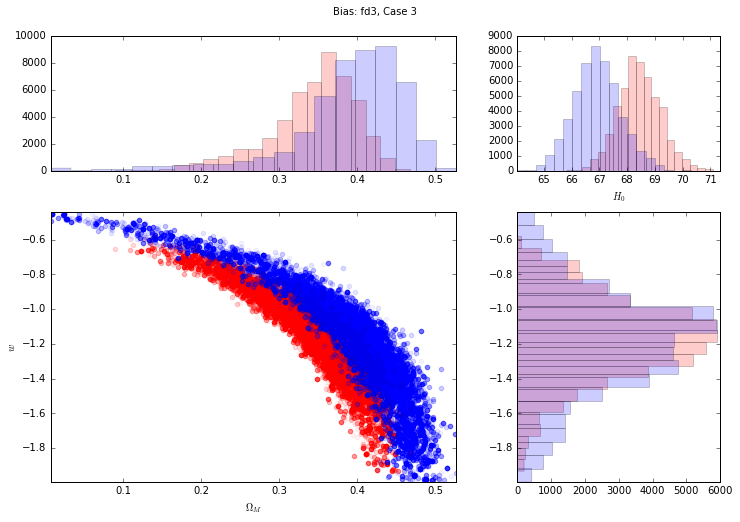

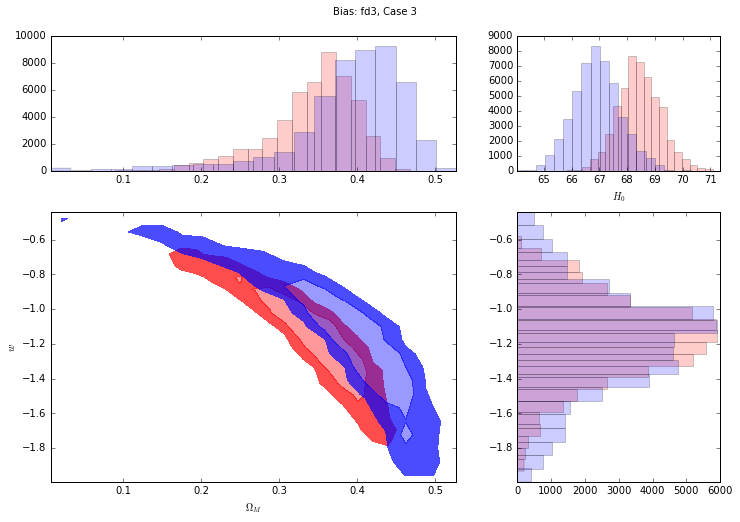

In [55]:
plot_conv_mcmc(fd3.case3,'Case 3',dataset='fd3')
plot_sct_hist(fd3,fd3.case3,'3',dataset='fd3',nb=20)
plot_contour_hist(fd3,fd3.case3,'3',dataset='fd3',nb=20)

In [44]:
#the other cases
MCMC_SNe(50000,fd3.case21,z_noise=True)
print('\n',fd3.case21.zn_acceptr)
MCMC_SNe(50000,fd3.case22,z_noise=True)
print('\n',fd3.case22.zn_acceptr)
MCMC_SNe(50000,fd3.case21,milne=True)
print('\n',fd3.case21.milne_acceptr)
MCMC_SNe(50000,fd3.case22,milne=True)
print('\n',fd3.case22.milne_acceptr)


 17.276
[##################################################]100%
 22.25
[##################################################]100%
 26.785999999999998
[##################################################]100%
 28.724


In [45]:
save_mcmc(fd3.case21,'fd3_case21_znoise',z_noise=True)
save_mcmc(fd3.case21,'fd3_case21_milne',milne=True)
save_mcmc(fd3.case22,'fd3_case22_znoise',z_noise=True)
save_mcmc(fd3.case22,'fd3_case22_milne',milne=True)

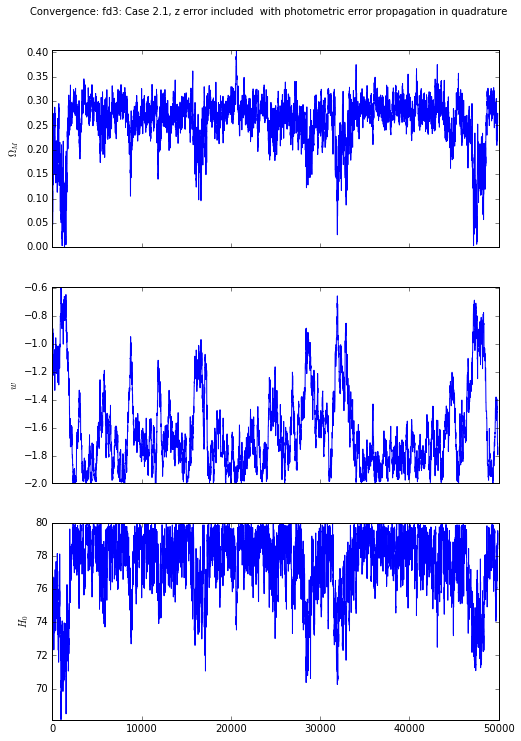

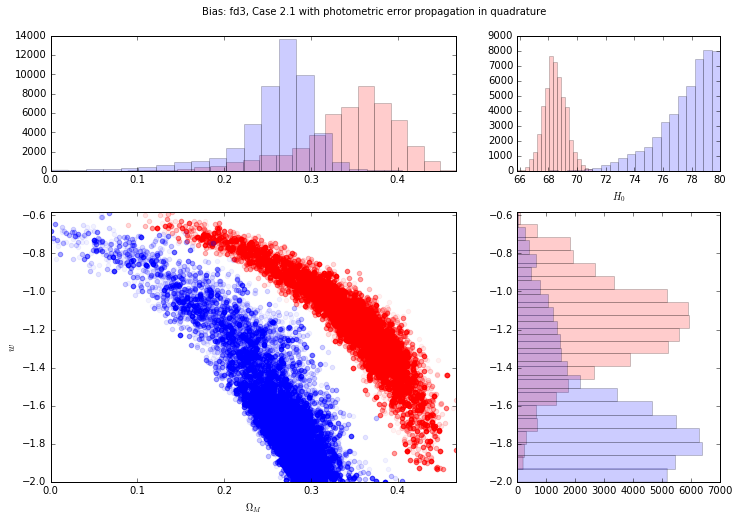

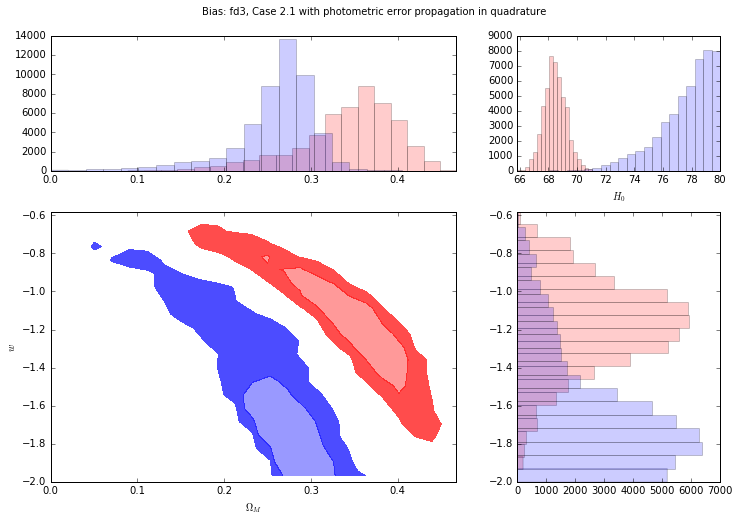

In [60]:
plot_conv_mcmc(fd3.case21,'Case 2.1, z error included ',z_noise=True,dataset='fd3')
plot_sct_hist(fd3,fd3.case21,'2.1',dataset='fd3',nb=20,z_noise=True)
plot_contour_hist(fd3,fd3.case21,'2.1',dataset='fd3',nb=20,z_noise=True)

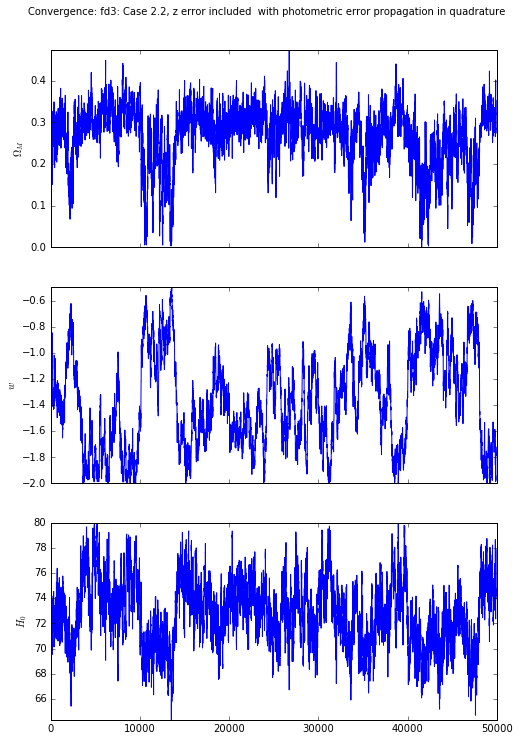

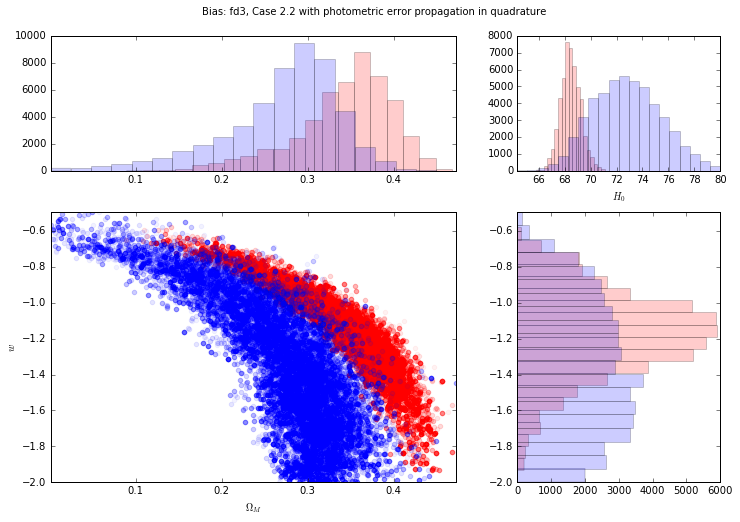

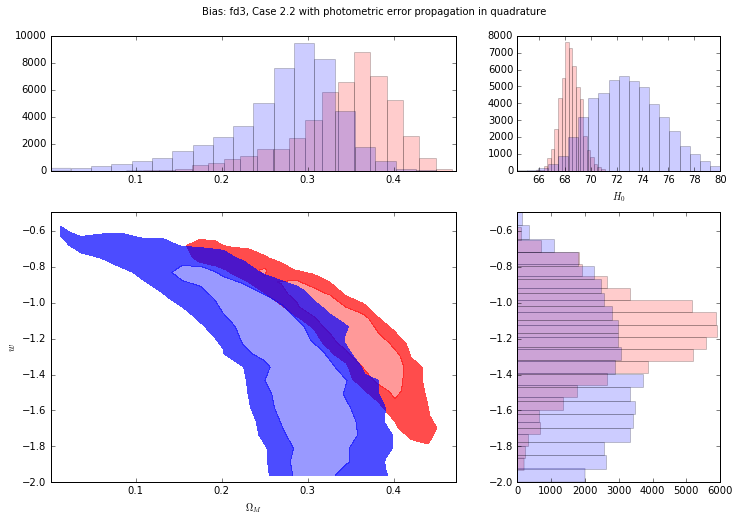

In [59]:
plot_conv_mcmc(fd3.case22,'Case 2.2, z error included ',z_noise=True,dataset='fd3')
plot_sct_hist(fd3,fd3.case22,'2.2',dataset='fd3',nb=20,z_noise=True)
plot_contour_hist(fd3,fd3.case22,'2.2',dataset='fd3',nb=20,z_noise=True)

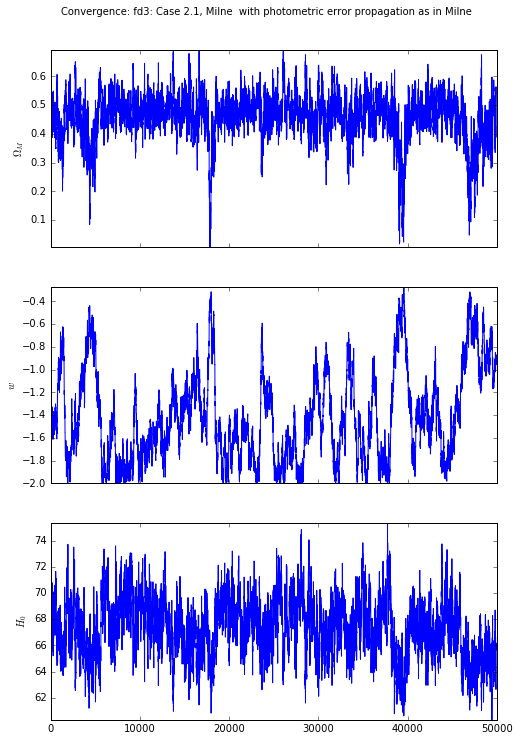

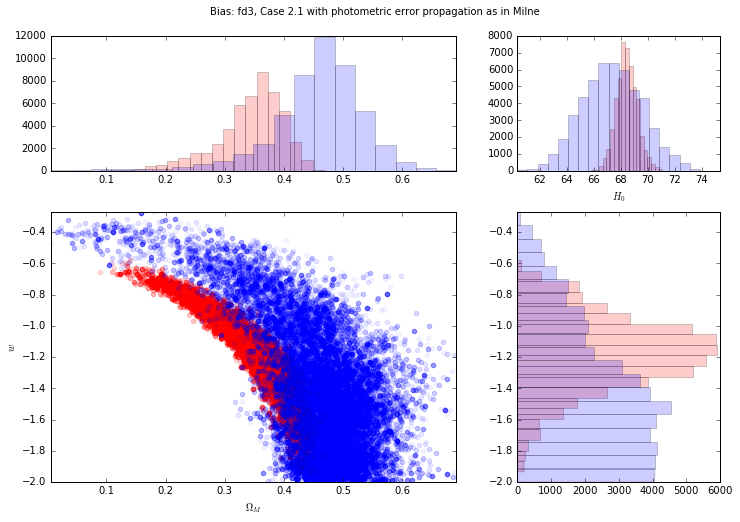

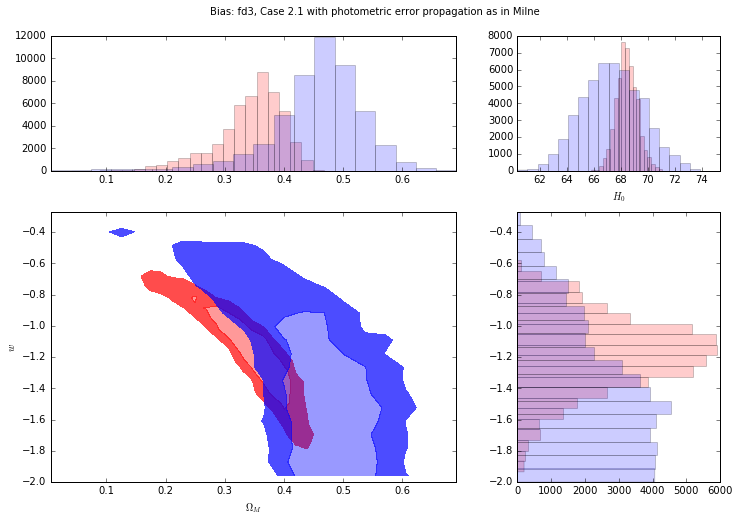

In [61]:
plot_conv_mcmc(fd3.case21,'Case 2.1, Milne ',milne=True,dataset='fd3')
plot_sct_hist(fd3,fd3.case21,'2.1',dataset='fd3',nb=20,milne=True)
plot_contour_hist(fd3,fd3.case21,'2.1',dataset='fd3',nb=20,milne=True)

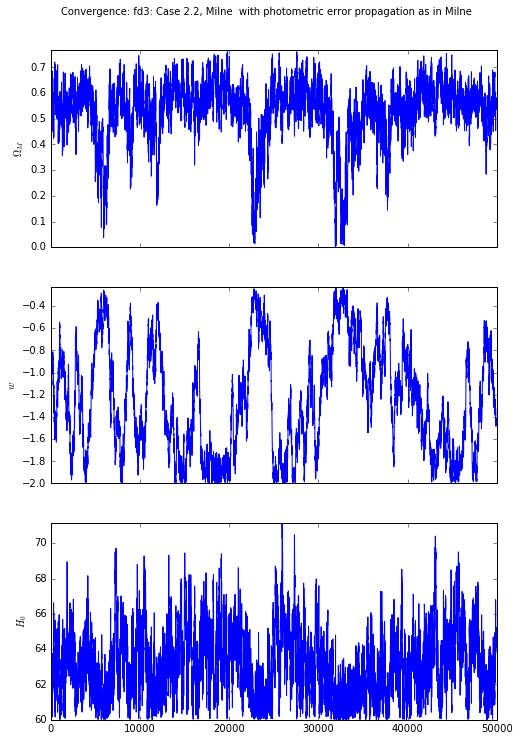

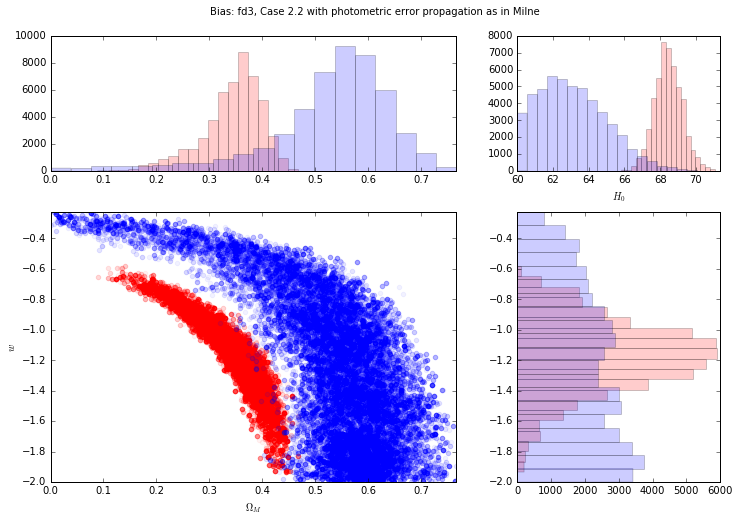

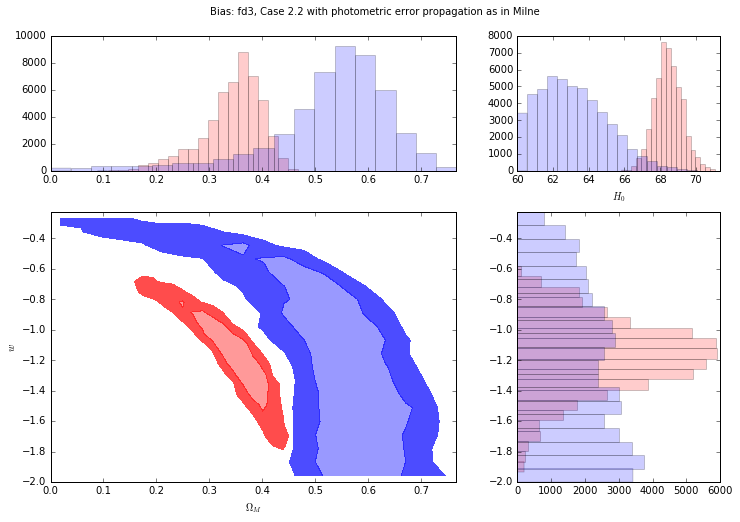

In [62]:
plot_conv_mcmc(fd3.case22,'Case 2.2, Milne ',milne=True,dataset='fd3')
plot_sct_hist(fd3,fd3.case22,'2.2',dataset='fd3',nb=20,milne=True)
plot_contour_hist(fd3,fd3.case22,'2.2',dataset='fd3',nb=20,milne=True)